<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20230219.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* Customer Analysis
* Iterators

In [1]:
import pandas as pd
import numpy as np 
import plotnine as gg
from plotnine import ggplot, aes
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import datetime, date, time, timezone, timedelta 
import os
import re

from functools import reduce
from collections import defaultdict
from scipy import stats 
from scipy.stats import norm

# Customer Analysis

In [2]:
np.sort(os.listdir())

array(['.config', '1_customers_dataset.csv',
       '1_order_payments_dataset.csv', '1_orders_dataset.csv',
       'KPMG_VI_New_raw_data_update_final.csv',
       'KPMG_VI_New_raw_data_update_final.xlsx',
       'WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv',
       'WA_Fn-UseC_-Telco-Customer-Churn.csv', 'ab_experiment.csv',
       'app_wau.csv', 'bz_data_analyis.csv', 'cookie_cats.csv',
       'ecommerce-data.csv', 'groceries.csv', 'lead_conversion.csv',
       'mall_customers.csv', 'match_result_test.csv',
       'mock_sales_data.csv', 'online_retail.xlsx',
       'online_retail_II.xlsx', 'sales.csv', 'sales_data_with_stores.csv',
       'sales_vs_discount.csv', 'sample-sales-data.csv', 'sample_data',
       'scanner_data.csv', 'test.csv'], dtype='<U49')

In [3]:
df = pd.read_csv('cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [6]:
cnt = pd.melt(df, id_vars = ['userid','version','sum_gamerounds'], var_name = 'retention', value_name = 'result')
cnt = cnt.groupby(['version','retention','result'])['userid'].count().reset_index().rename(columns = {'userid':'cnt'})
cnt = cnt[cnt['result'] == True]
cnt

,version,retention,result,cnt
1,gate_30,retention_1,True,20034
3,gate_30,retention_7,True,8502
5,gate_40,retention_1,True,20119
7,gate_40,retention_7,True,8279


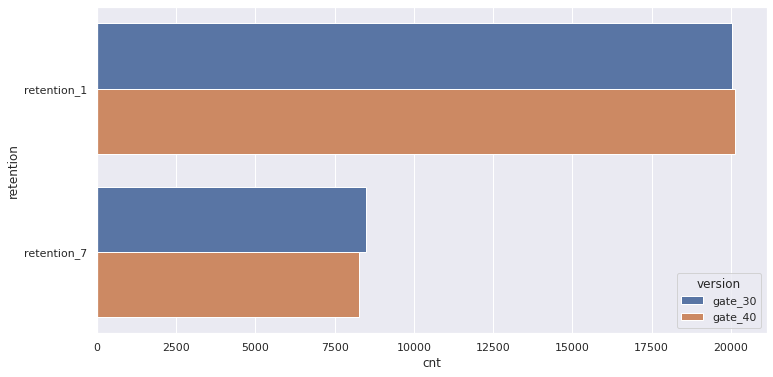

In [8]:
sns.set(rc = {'figure.figsize':[12,6]})
sns.barplot(data = cnt, x = 'cnt', y = 'retention', hue = 'version')
plt.show()

In [15]:
cnt2 = pd.melt(df, id_vars = ['userid','version','sum_gamerounds'], var_name = 'retention', value_name = 'result')
cnt2 = cnt2.groupby(['version','retention','result'])['sum_gamerounds'].quantile([.25, .5, .75, .95, .55]).reset_index(name = 'quantile')
cnt2 = cnt2[cnt2['result'] == True]
cnt2

,version,retention,result,level_3,quantile
5,gate_30,retention_1,True,0.25,22.0
6,gate_30,retention_1,True,0.50,48.0
7,gate_30,retention_1,True,0.75,111.0
8,gate_30,retention_1,True,0.95,339.0
9,gate_30,retention_1,True,0.55,55.0
15,gate_30,retention_7,True,0.25,48.0
16,gate_30,retention_7,True,0.50,105.0
17,gate_30,retention_7,True,0.75,208.0
18,gate_30,retention_7,True,0.95,493.0
19,gate_30,retention_7,True,0.55,120.0


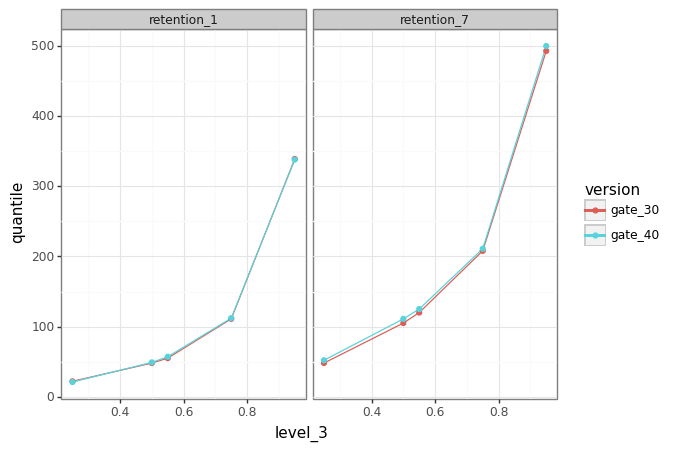

<ggplot: (8730284844409)>

In [16]:
(
    ggplot(cnt2, aes('level_3','quantile', color = 'version', group = 'version')) +
    gg.geom_line() +
    gg.geom_point() +
    gg.facet_grid('~retention') +
    gg.theme_bw()
)

In [17]:
df = df[df['sum_gamerounds'] <= 10000]

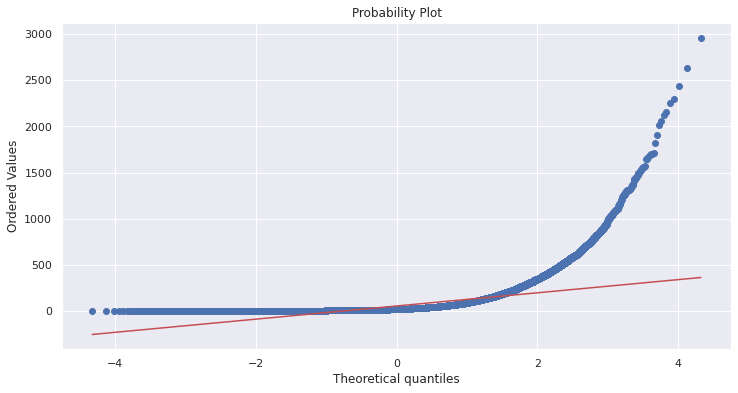

In [18]:
stats.probplot(df['sum_gamerounds'], dist = 'norm', plot = plt)
plt.show()

In [19]:
stat, p = stats.chisquare(df['sum_gamerounds'])
print(str(stat), '\t', str(p))

18528909.99029161 	 0.0


In [23]:
res = stats.anderson(df['sum_gamerounds'])
print(res)
res2 = zip(res.critical_values, res.significance_level)
[f'probably Gaussian : critical value {crit} significance level {sig}'
 if crit > sig 
 else f'probably Gaussian : critical value {crit} significance level {sig}'
 for crit, sig in res2
]

AndersonResult(statistic=13369.548966017013, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


['probably Gaussian : critical value 0.576 significance level 15.0',
 'probably Gaussian : critical value 0.656 significance level 10.0',
 'probably Gaussian : critical value 0.787 significance level 5.0',
 'probably Gaussian : critical value 0.918 significance level 2.5',
 'probably Gaussian : critical value 1.092 significance level 1.0']

In [25]:
n = 1000 
boots = pd.DataFrame(
    [df.sample(frac = .1, replace=  True).groupby(['version'])['sum_gamerounds'].mean() for i in range(n)]
)
boots

version,gate_30,gate_40
sum_gamerounds,53.875084,51.922640
sum_gamerounds,53.504820,54.358249
sum_gamerounds,49.522318,52.019265
sum_gamerounds,49.714158,51.913455
sum_gamerounds,52.582630,52.221287
...,...,...
sum_gamerounds,50.038018,52.909565
sum_gamerounds,51.381678,52.343939
sum_gamerounds,51.695234,53.040000
sum_gamerounds,52.367338,48.237495


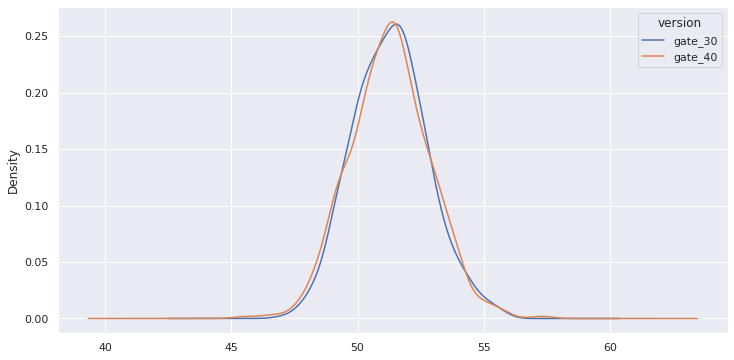

In [26]:
boots.plot.kde()

In [27]:
diff = boots['gate_30'] - boots['gate_40']
len(diff[diff>0])/n

0.51

Text(0.5, 0, 'difference of boostrapped sum_gamerounds')

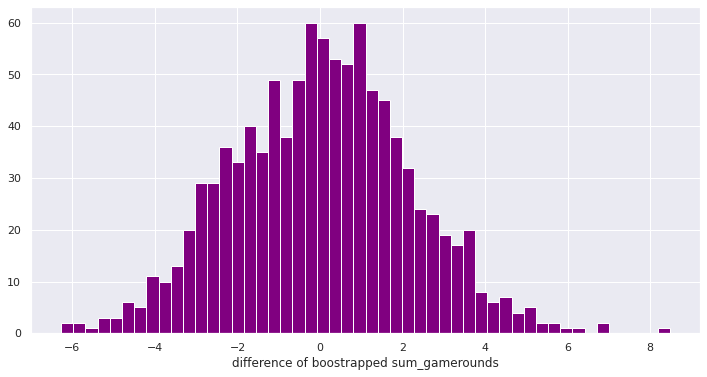

In [28]:
plt.hist(diff, bins = 50, color = 'purple')
plt.xlabel('difference of boostrapped sum_gamerounds')

# Iterators

In [29]:
users = [{'mail': 'gregorythomas@gmail.com', 'name': 'Brett Holland', 'sex': 'M', 'age': 73},
 {'mail': 'hintoncynthia@hotmail.com', 'name': 'Madison Martinez', 'sex': 'F', 'age': 29},
 {'mail': 'wwagner@gmail.com', 'name': 'Michael Jenkins', 'sex': 'M', 'age': 51},
 {'mail': 'daniel79@gmail.com', 'name': 'Karen Rodriguez', 'sex': 'F', 'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]
users

[{'mail': 'gregorythomas@gmail.com',
  'name': 'Brett Holland',
  'sex': 'M',
  'age': 73},
 {'mail': 'hintoncynthia@hotmail.com',
  'name': 'Madison Martinez',
  'sex': 'F',
  'age': 29},
 {'mail': 'wwagner@gmail.com',
  'name': 'Michael Jenkins',
  'sex': 'M',
  'age': 51},
 {'mail': 'daniel79@gmail.com',
  'name': 'Karen Rodriguez',
  'sex': 'F',
  'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]

In [30]:
{k : eval(f'reduce(lambda acc, cur : acc + [cur["{k}"]], users, [])') for k in list(users[0].keys())}

{'mail': ['gregorythomas@gmail.com',
  'hintoncynthia@hotmail.com',
  'wwagner@gmail.com',
  'daniel79@gmail.com',
  'ujackson@gmail.com'],
 'name': ['Brett Holland',
  'Madison Martinez',
  'Michael Jenkins',
  'Karen Rodriguez',
  'Amber Rhodes'],
 'sex': ['M', 'F', 'M', 'F', 'F'],
 'age': [73, 29, 51, 32, 42]}